In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt


# 1. 데이터 생성

In [57]:
def adjust_values_by_time(hour, mean_value, peak_value):
    """
    시간대에 따라 값을 조정하는 함수. 주간에는 peak_value를, 야간에는 mean_value의 일부를 사용합니다.
    """
    if 6 <= hour <= 18:
        return peak_value * np.sin(np.pi * (hour - 6) / 12)
    else:
        return mean_value * 0.1

def generate_detailed_solar_data(start_date, end_date):
    data_list = []
    num_days = (end_date - start_date).days + 1

    for day in range(num_days):
        date = start_date + pd.Timedelta(days=day)
        for hour in range(24):
            datetime = pd.Timestamp(date.year, date.month, date.day, hour)
            temperature = np.random.normal(25, 5)
            humidity = np.random.normal(50, 10)
            rainfall = np.random.choice([0, 0, 0, 1, 2, 5, 10], p=[0.7, 0.1, 0.1, 0.05, 0.02, 0.02, 0.01])
            DHI = np.random.normal(80, 30)
            DNI = np.random.normal(300, 100)
            pv_current = np.random.normal(8, 2)
            plant_current = np.random.normal(80, 20)
            plant_voltage = np.random.normal(400, 100)
            power = pv_current * plant_voltage  # 실제 발전량 계산
            sunshine_duration = adjust_values_by_time(hour, 0, 1) * 12  # 일조 시간 계산
            atmospheric_clarity = np.random.normal(0.75, 0.1)
            panel_orientation = np.random.choice(['South', 'East', 'West'], p=[0.7, 0.15, 0.15])
            albedo = np.random.normal(0.3, 0.05)
            age = np.random.choice(range(1, 21))
            maintenance = np.random.choice(['Good', 'Average', 'Poor'], p=[0.6, 0.3, 0.1])
            climate_change_effect = np.random.choice(['None', 'Low', 'Moderate', 'High'], p=[0.7, 0.2, 0.08, 0.02])
            grid_integration = np.random.choice(['Integrated', 'Isolated'], p=[0.8, 0.2])
            defect = 1 if rainfall > 10 or maintenance == 'Poor' else 0  # 결함 조건 설정

            data_list.append({
                "datetime": datetime,               # 날짜와 시간
                "temperature": temperature,         # 온도 (°C)
                "humidity": humidity,               # 상대 습도 (%)
                "rainfall": rainfall,               # 강수량 (mm)
                "DHI": DHI,                         # 확산 일사량 (W/m^2), 태양광이 대기에 의해 산란되어 지표에 도달하는 빛의 양
                "DNI": DNI,                         # 직접 일사량 (W/m^2), 태양으로부터 직접적으로 받는 빛의 양
                "pv_current": pv_current,           # 태양광 패널 전류 (A), 태양광 패널이 생성하는 전류의 양
                "plant_current": plant_current,     # 발전소 전류 (A), 발전소 전체에서 생성되는 전류의 양
                "plant_voltage": plant_voltage,     # 발전소 전압 (V), 발전소 전체의 전압
                "power": power,                     # 발전량 (W), 발전소에서 생성되는 전력의 양
                "sunshine_duration": sunshine_duration,         # 일조 시간 (시간), 태양 빛이 지표에 도달하는 시간의 길이
                "atmospheric_clarity": atmospheric_clarity,     # 대기 맑음 정도, 대기의 투명도나 맑음 정도를 나타냄
                "panel_orientation": panel_orientation,         # 패널 방향, 태양광 패널이 설치된 방향 (남, 동, 서)
                "albedo": albedo,                               # 지표 반사율, 지표에서 반사되는 태양광의 비율
                "age": age,                                     # 패널 나이 (년), 태양광 패널이 사용된 기간
                "maintenance": maintenance,                     # 유지보수 상태, 패널의 유지보수 상태 (좋음, 보통, 나쁨)
                "climate_change_effect": climate_change_effect, # 기후 변화 영향, 기후 변화가 발전소에 미치는 영향 정도
                "grid_integration": grid_integration,           # 그리드 통합 여부, 발전소가 전력망에 통합되어 있는지 여부
                "defect": defect                                # 결함 여부, 발전소나 패널에 결함이 있는지 여부 (0: 정상, 1: 결함)
            })


    return pd.DataFrame(data_list)

# 데이터 생성 범위 설정
start_date = pd.to_datetime("2010-01-01")
end_date = pd.to_datetime("2024-02-28")

# 데이터 생성
detailed_solar_data = generate_detailed_solar_data(start_date, end_date)

# 첫 5개 데이터 확인
print(detailed_solar_data.head())

# 데이터 저장
detailed_solar_data.to_csv("C:/Users/typar/OneDrive/바탕 화면/개인/방송대/태양광/f_solar_data.csv", index=False)


             datetime  temperature   humidity  rainfall         DHI  \
0 2010-01-01 00:00:00    24.304611  58.498330         0   30.161974   
1 2010-01-01 01:00:00    30.696339  52.641787         0   48.111530   
2 2010-01-01 02:00:00    22.312889  44.882394         0   87.746077   
3 2010-01-01 03:00:00    19.094494  63.039198         0   55.744842   
4 2010-01-01 04:00:00    30.123849  62.863771         0  112.614106   

          DNI  pv_current  plant_current  plant_voltage        power  \
0  535.288991    9.961992      94.711855     456.933986  4551.972624   
1  264.397877   11.128360     121.606423     393.722064  4381.481045   
2  332.213622   10.390757      63.278564     475.171154  4937.388186   
3  355.340694   10.184181      65.629976     315.730343  3215.454944   
4  217.029155    7.378328      67.858327     467.077254  3446.249084   

   sunshine_duration  atmospheric_clarity panel_orientation    albedo  age  \
0                0.0             0.478840              West  0

#### 데이터 불러오기

In [58]:
data = pd.read_csv('g_solar_data.csv')
data.columns

Index(['datetime', 'temperature', 'humidity', 'rainfall', 'DHI', 'DNI',
       'pv_current', 'plant_current', 'plant_voltage', 'power',
       'sunshine_duration', 'atmospheric_clarity', 'panel_orientation',
       'albedo', 'age', 'maintenance', 'climate_change_effect',
       'grid_integration', 'defect'],
      dtype='object')

# 2. 분석

## a. 태양광 발전량과 기후 요인 간의 상관 관계 분석

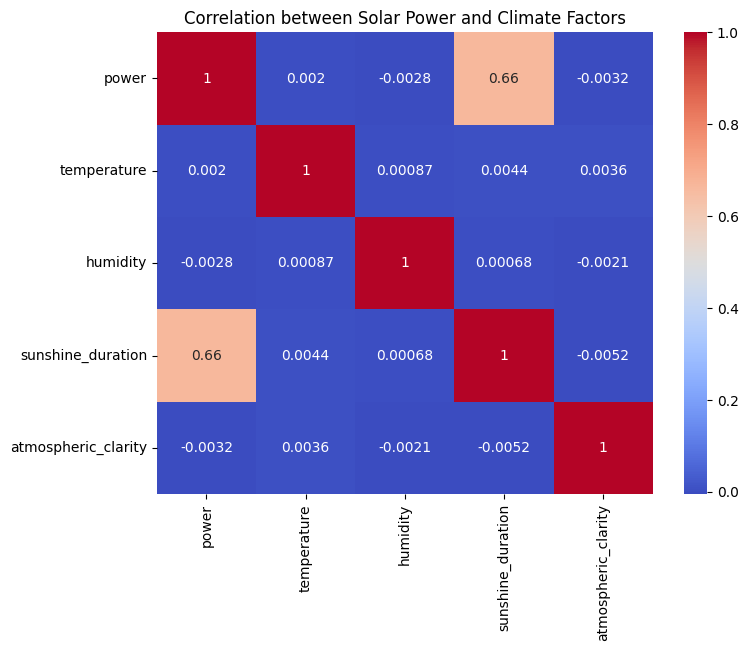

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# 태양광 발전량과 기후 요인 간의 상관 관계 계산
climate_factors = ['temperature', 'humidity', 'sunshine_duration', 'atmospheric_clarity']
correlation_matrix = data[['power'] + climate_factors].corr()

# 상관 관계 히트맵 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation between Solar Power and Climate Factors')
plt.show()


## b. 태양광 패널의 유지보수 상태 및 나이가 발전 효율에 미치는 영향 분석


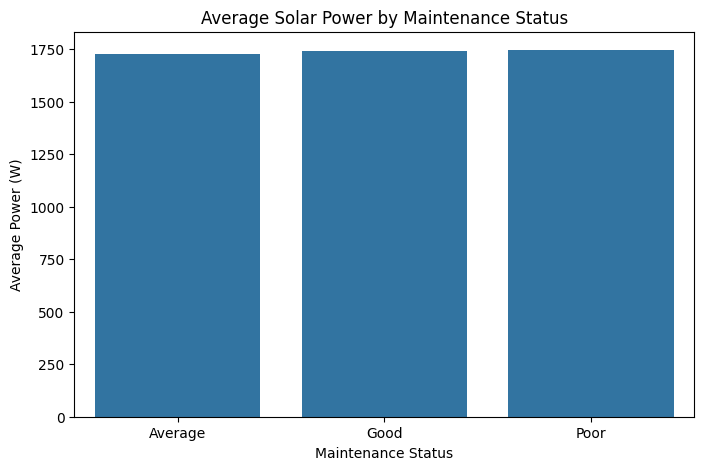

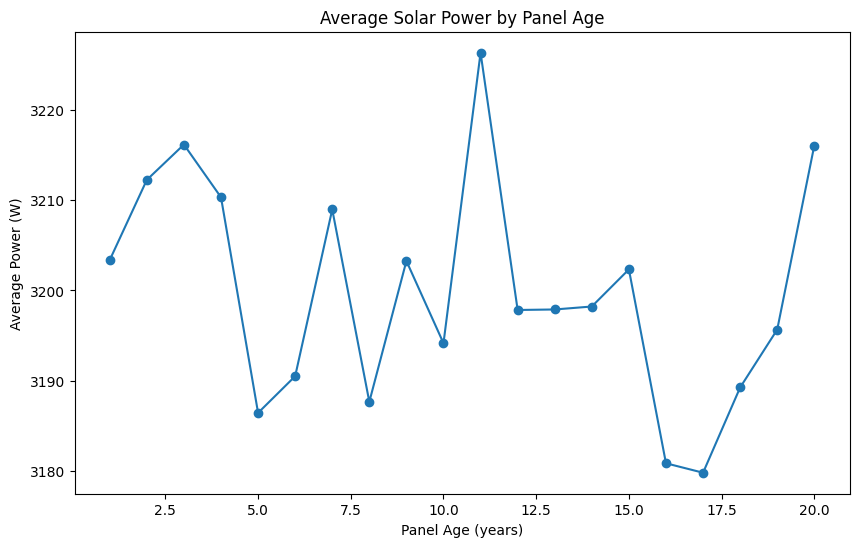

In [10]:
# 유지보수 상태에 따른 평균 발전량
maintenance_power = data.groupby('maintenance')['power'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(x='maintenance', y='power', data=maintenance_power)
plt.title('Average Solar Power by Maintenance Status')
plt.xlabel('Maintenance Status')
plt.ylabel('Average Power (W)')
plt.show()

# 패널 나이에 따른 평균 발전량
age_power = detailed_solar_data.groupby('age')['power'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(age_power['age'], age_power['power'], marker='o')
plt.title('Average Solar Power by Panel Age')
plt.xlabel('Panel Age (years)')
plt.ylabel('Average Power (W)')
plt.show()


## c. 태양광 발전량의 시간대별 변화 분석


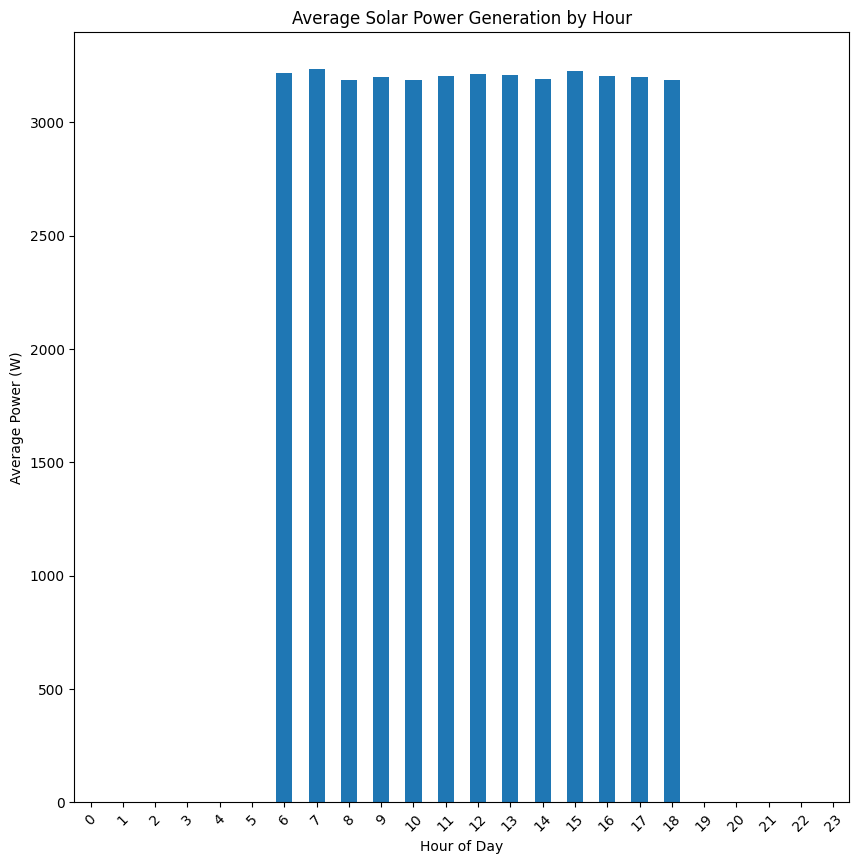

In [16]:
# 데이터 불러오기 (예제에서는 데이터가 이미 detailed_solar_data 변수에 저장되어 있다고 가정)
# detailed_solar_data = pd.read_csv("f_solar_data.csv")

# 'datetime' 열을 datetime 형태로 변환
data['datetime'] = pd.to_datetime(data['datetime'])

# 시간별로 평균 발전량 계산
hourly_power = data.groupby(data['datetime'].dt.hour)['power'].mean()

# 시간대별 평균 발전량 시각화
plt.figure(figsize=(10, 10))
hourly_power.plot(kind='bar')
plt.title('Average Solar Power Generation by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (W)')
plt.xticks(rotation=45)
plt.show()


## d.일별 총 발전량 시각화

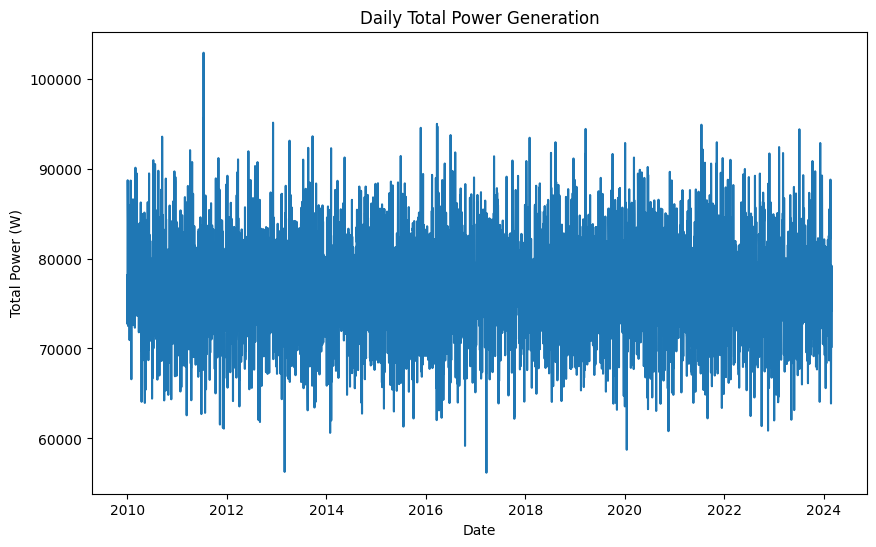

In [23]:
# 날짜별로 그룹화하여 총 발전량 계산
daily_power_sum = detailed_solar_data.groupby(detailed_solar_data['datetime'].dt.date)['power'].sum()

# 시각화
plt.figure(figsize=(10, 6))
daily_power_sum.plot(kind='line')
plt.title('Daily Total Power Generation')
plt.xlabel('Date')
plt.ylabel('Total Power (W)')
plt.show()


## e. 패널 방향별 발전 효율성 비교

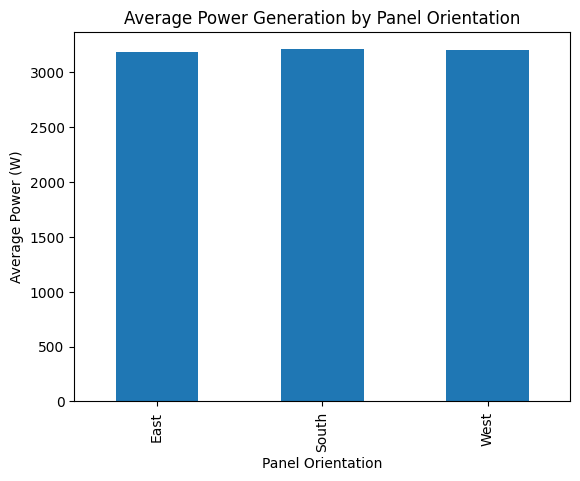

In [24]:
# 패널 방향별로 그룹화하여 평균 발전량 계산
panel_orientation_avg_power = detailed_solar_data.groupby('panel_orientation')['power'].mean()

# 시각화
panel_orientation_avg_power.plot(kind='bar')
plt.title('Average Power Generation by Panel Orientation')
plt.xlabel('Panel Orientation')
plt.ylabel('Average Power (W)')
plt.show()


## f. 유지보수 상태별 발전량 비교

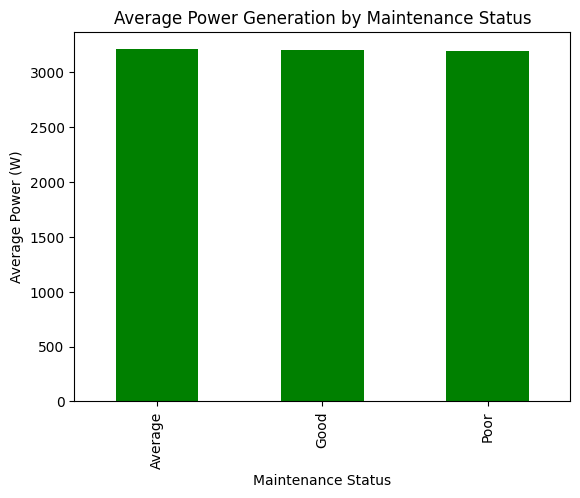

In [25]:
# 유지보수 상태별로 그룹화하여 평균 발전량 계산
maintenance_avg_power = detailed_solar_data.groupby('maintenance')['power'].mean()

# 시각화
maintenance_avg_power.plot(kind='bar', color='green')
plt.title('Average Power Generation by Maintenance Status')
plt.xlabel('Maintenance Status')
plt.ylabel('Average Power (W)')
plt.show()


## g. 기후 변화 영향 분석


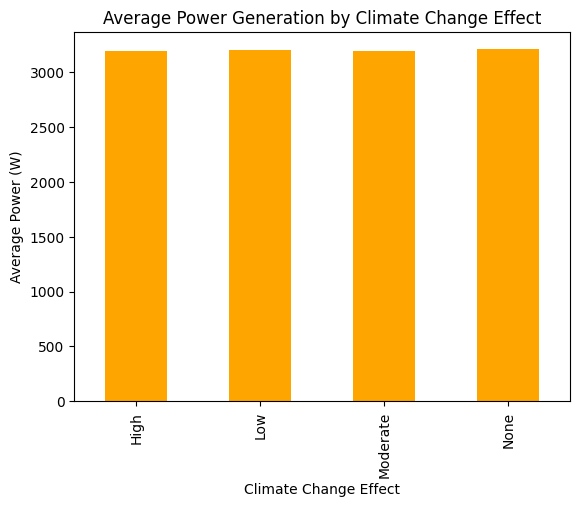

In [26]:
# 기후 변화 영향별로 그룹화하여 평균 발전량 계산
climate_change_effect_avg_power = detailed_solar_data.groupby('climate_change_effect')['power'].mean()

# 시각화
climate_change_effect_avg_power.plot(kind='bar', color='orange')
plt.title('Average Power Generation by Climate Change Effect')
plt.xlabel('Climate Change Effect')
plt.ylabel('Average Power (W)')
plt.show()


## 이상치 탐색.

In [39]:
data_columns = data.columns.tolist()
data_columns

['datetime',
 'temperature',
 'humidity',
 'rainfall',
 'DHI',
 'DNI',
 'pv_current',
 'plant_current',
 'plant_voltage',
 'power',
 'sunshine_duration',
 'atmospheric_clarity',
 'panel_orientation',
 'albedo',
 'age',
 'maintenance',
 'climate_change_effect',
 'grid_integration',
 'defect',
 'DATE',
 'TIME',
 'DAY',
 'MONTH']

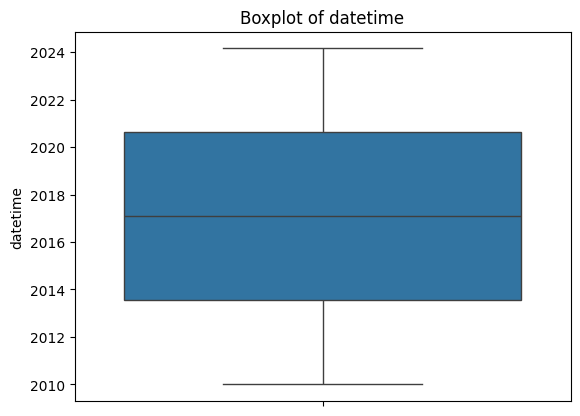

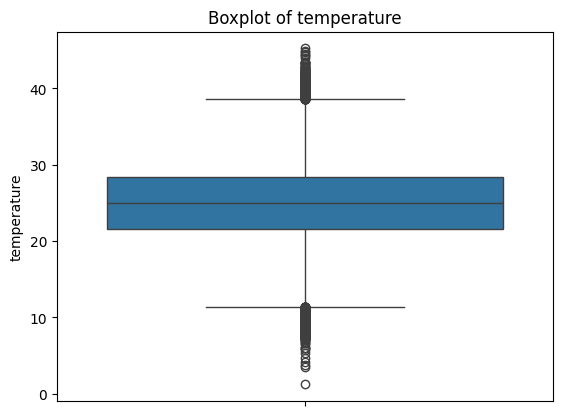

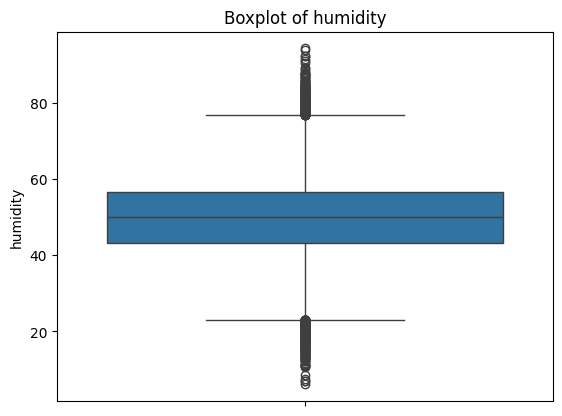

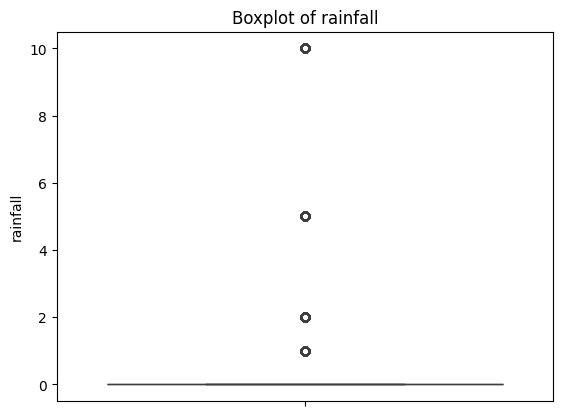

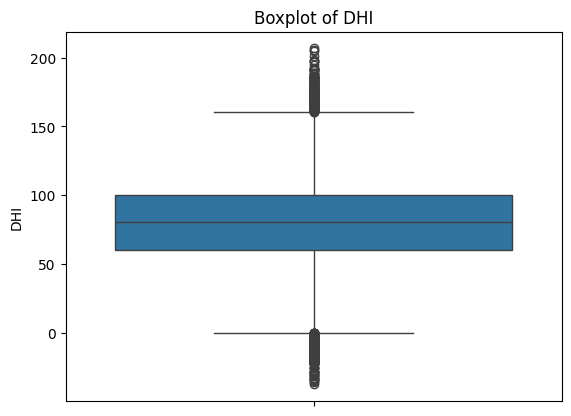

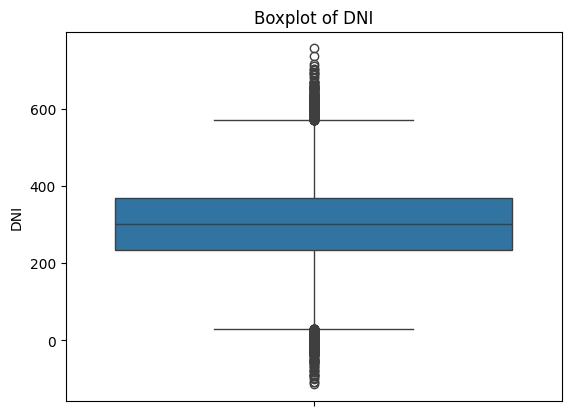

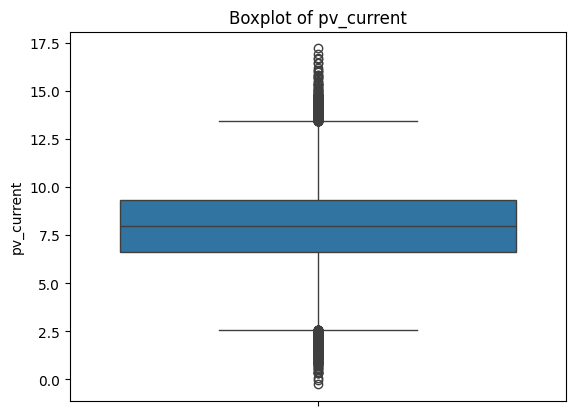

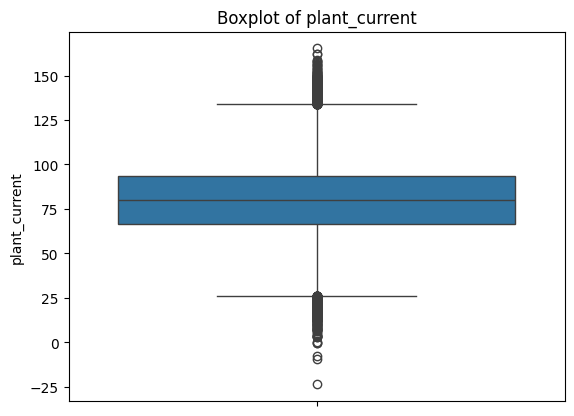

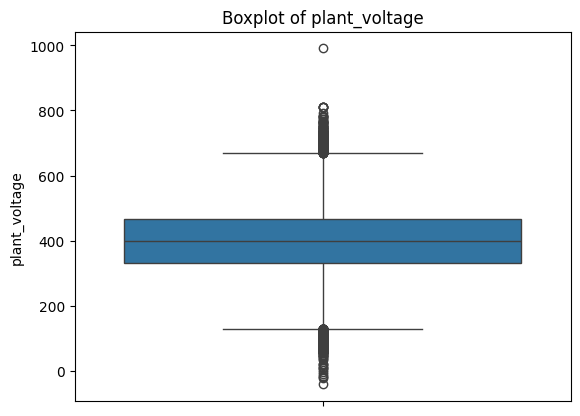

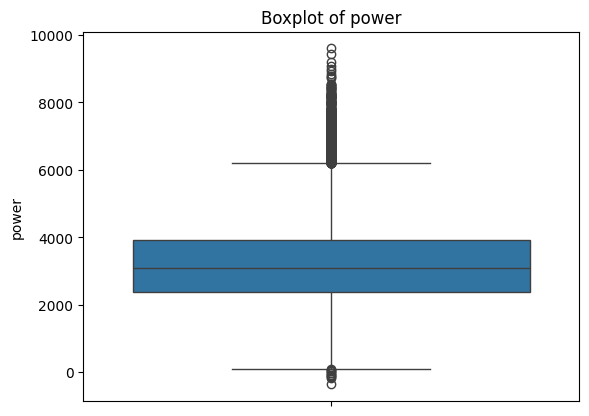

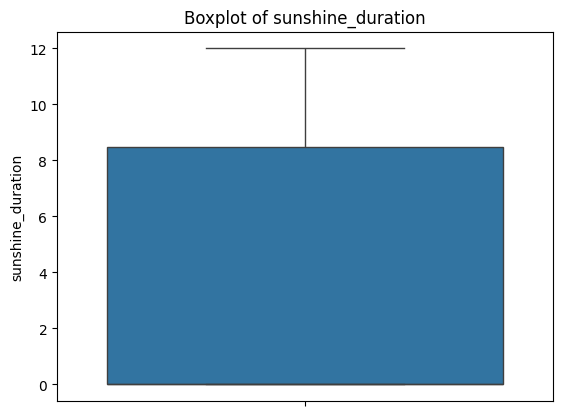

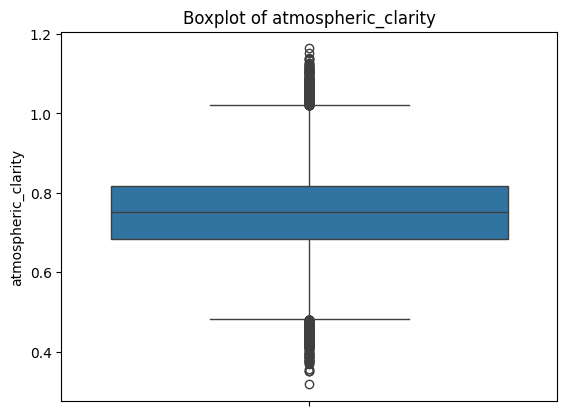

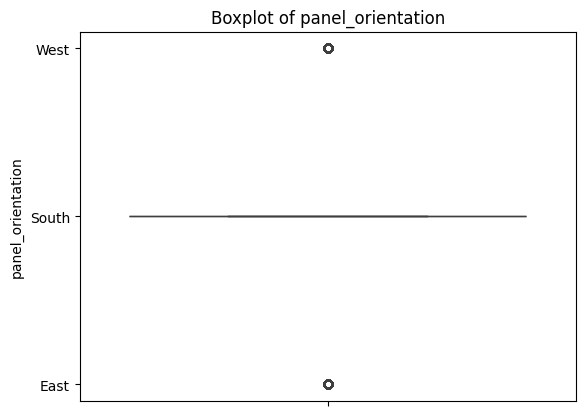

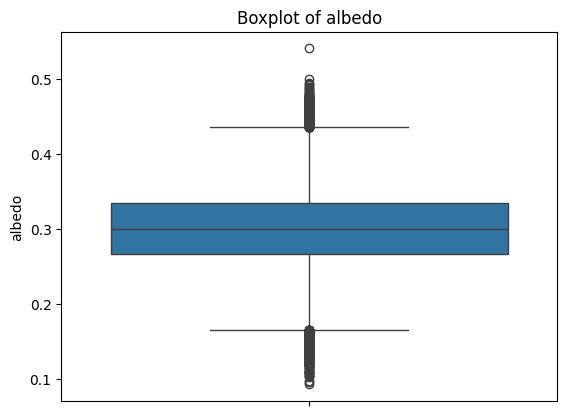

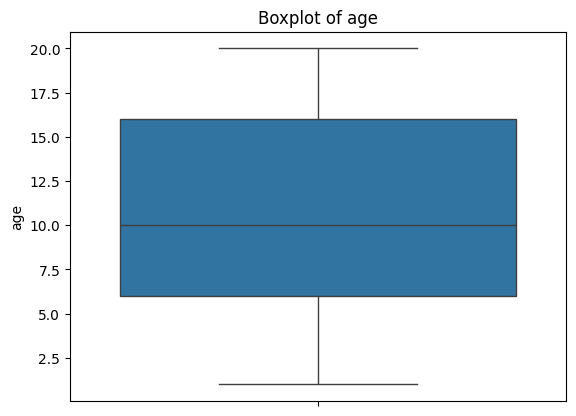

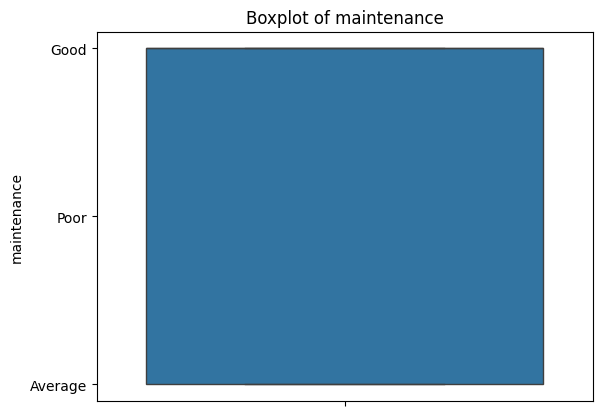

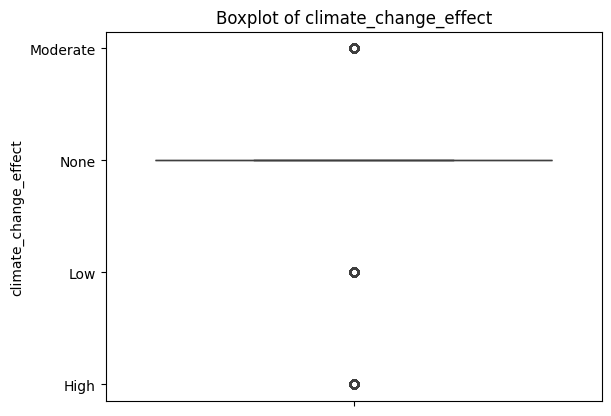

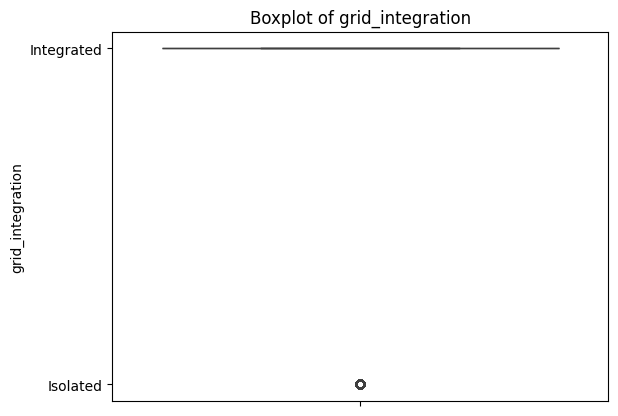

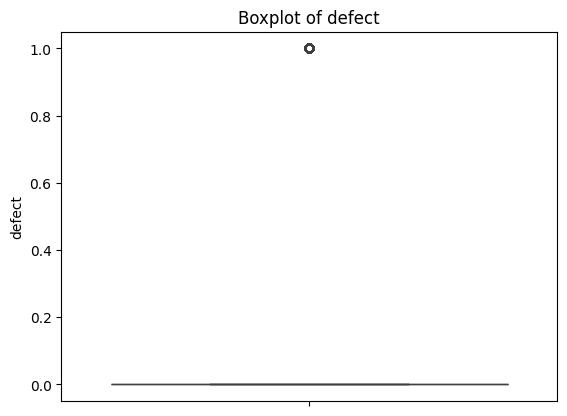

An error occurred with column DATE: 'DATE'
An error occurred with column TIME: 'TIME'
An error occurred with column DAY: 'DAY'
An error occurred with column MONTH: 'MONTH'


In [40]:
for column in data_columns:
    try:
        sns.boxplot(y=detailed_solar_data[column])
        plt.title(f'Boxplot of {column}')
        plt.show()
    except Exception as e:  
        print(f"Error column =  {column}: {e}")
        continue  # 오류 발생 시, 해당 컬럼을 건너뛰고 다음 컬럼으로 넘어갑니다.


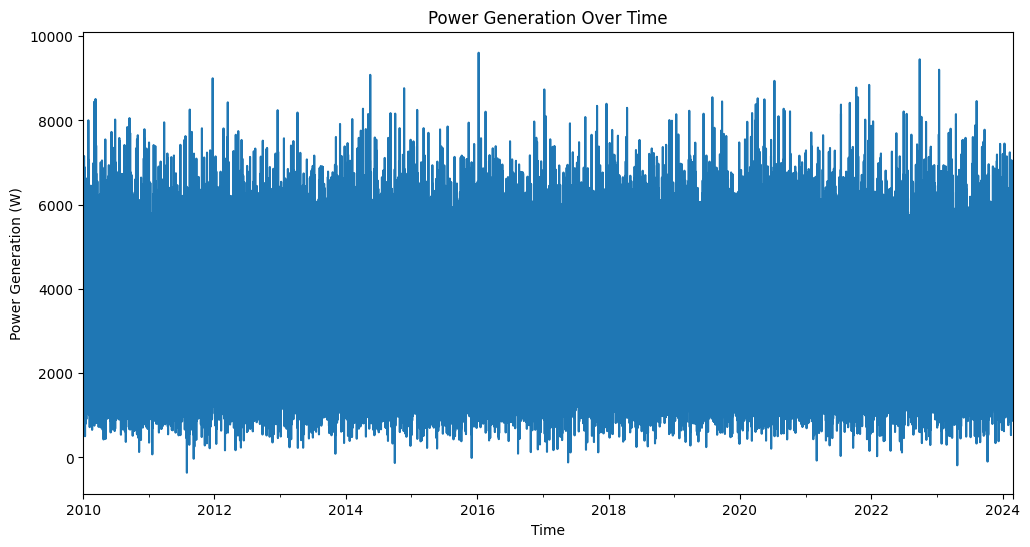

In [41]:
# 시계열

# 발전량의 시간에 따른 추세 시각화
plt.figure(figsize=(12, 6))
detailed_solar_data.set_index('datetime')['power'].plot()
plt.title('Power Generation Over Time')
plt.xlabel('Time')
plt.ylabel('Power Generation (W)')
plt.show()


# 3. Preprocessing

In [42]:
data.head(3)

,datetime,temperature,humidity,rainfall,DHI,DNI,pv_current,plant_current,plant_voltage,power,...,albedo,age,maintenance,climate_change_effect,grid_integration,defect,DATE,TIME,DAY,MONTH
0,2010-01-01 00:00:00,19.755584,57.666783,5,90.794842,132.780770,9.763666,65.633642,391.766089,0.0,...,0.357467,13,Poor,NaN,Integrated,1,2010-01-01,00:00:00,1,1
1,2010-01-01 01:00:00,27.587310,37.989266,0,79.681515,310.306207,9.654877,82.278851,452.020236,0.0,...,0.300148,10,Good,NaN,Integrated,0,2010-01-01,01:00:00,1,1
2,2010-01-01 02:00:00,22.526554,44.370571,0,78.450892,179.489017,7.478556,83.000563,404.570816,0.0,...,0.271021,7,Good,NaN,Integrated,0,2010-01-01,02:00:00,1,1


In [61]:
# 생성한 Data datetime을 각 숫자로 변경
data["DATE"] = pd.to_datetime(data["datetime"]).dt.date
data["TIME"] = pd.to_datetime(data["datetime"]).dt.time
data['DAY'] = pd.to_datetime(data['datetime']).dt.day
data['MONTH'] = pd.to_datetime(data['datetime']).dt.month

print(data.columns)
data[["DATE", "TIME", 'DAY', 'MONTH']].tail()

Index(['datetime', 'temperature', 'humidity', 'rainfall', 'DHI', 'DNI',
       'pv_current', 'plant_current', 'plant_voltage', 'power',
       'sunshine_duration', 'atmospheric_clarity', 'panel_orientation',
       'albedo', 'age', 'maintenance', 'climate_change_effect',
       'grid_integration', 'defect', 'DATE', 'TIME', 'DAY', 'MONTH'],
      dtype='object')


,DATE,TIME,DAY,MONTH
123619,2024-02-07,19:00:00,7,2
123620,2024-02-07,20:00:00,7,2
123621,2024-02-07,21:00:00,7,2
123622,2024-02-07,22:00:00,7,2
123623,2024-02-07,23:00:00,7,2


In [62]:
# 데이터 값의 분포 조사
data.describe(include=[object])

,datetime,panel_orientation,maintenance,climate_change_effect,grid_integration,DATE,TIME
count,123624,123624,123624,37155,123624,123624,123624
unique,123624,3,3,3,2,5151,24
top,2010-01-01 00:00:00,South,Good,Low,Integrated,2010-01-01,00:00:00
freq,1,86508,74103,24665,98955,24,5151


In [84]:
# 각 컬럼의 데이터 타입과 고유값의 수를 기반으로 범주형과 연속형 구분

continuous_var = []
Categorical_var = []

for column in data.columns:
    # 고유값의 수
    unique_values = data[column].nunique()
    
    # 데이터 타입
    dtype = data[column].dtype
    
    # 범주형 데이터 판별: 문자열 타입이거나 고유값의 수가 적은 경우
    # 여기서는 임계값으로 고유값의 수를 10으로 설정함. 필요에 따라 조정할 수 있음
    if dtype == 'object' or unique_values <= 10:
        Categorical_var.append(column)
        print(f'{column}: 범주형 (고유값 수: {unique_values})')
    else:
        continuous_var.append(column)
        print(f'{column}: 연속형 (고유값 수: {unique_values})')

print(f'연속형 변수 List : [{continuous_var}]')
print(f'범주형 변수 List : [{Categorical_var}]')


datetime: 범주형 (고유값 수: 123624)
temperature: 연속형 (고유값 수: 123624)
humidity: 연속형 (고유값 수: 123624)
rainfall: 범주형 (고유값 수: 5)
DHI: 연속형 (고유값 수: 123624)
DNI: 연속형 (고유값 수: 123624)
pv_current: 연속형 (고유값 수: 123624)
plant_current: 연속형 (고유값 수: 123624)
plant_voltage: 연속형 (고유값 수: 123624)
power: 연속형 (고유값 수: 66964)
sunshine_duration: 범주형 (고유값 수: 9)
atmospheric_clarity: 연속형 (고유값 수: 123624)
panel_orientation: 범주형 (고유값 수: 3)
albedo: 연속형 (고유값 수: 123624)
age: 연속형 (고유값 수: 20)
maintenance: 범주형 (고유값 수: 3)
climate_change_effect: 범주형 (고유값 수: 4)
grid_integration: 범주형 (고유값 수: 2)
defect: 범주형 (고유값 수: 2)
DATE: 범주형 (고유값 수: 5151)
TIME: 연속형 (고유값 수: 24)
DAY: 연속형 (고유값 수: 31)
MONTH: 연속형 (고유값 수: 12)
연속형 변수 List : [['temperature', 'humidity', 'DHI', 'DNI', 'pv_current', 'plant_current', 'plant_voltage', 'power', 'atmospheric_clarity', 'albedo', 'age', 'TIME', 'DAY', 'MONTH']]
범주형 변수 List : [['datetime', 'rainfall', 'sunshine_duration', 'panel_orientation', 'maintenance', 'climate_change_effect', 'grid_integration', 'defect', 'DA

In [85]:
# 데이터 불러오기

# LabelEncoder 객체 생성
encoder = LabelEncoder()

# 범주형 컬럼 리스트
categorical_columns = Categorical_var


'''
"panel_orientation"        # 패널 방향, 태양광 패널이 설치된 방향 (남, 동, 서)
"maintenance":             # 유지보수 상태, 패널의 유지보수 상태 (좋음, 보통, 나쁨)
"climate_change_effect"    # 기후 변화 영향, 기후 변화가 발전소에 미치는 영향 정도
"grid_integration"         # 그리드 통합 여부, 발전소가 전력망에 통합되어 있는지 여부
'''

# 범주형 컬럼을 반복하며 Label Encoding 수행
for column in categorical_columns:
    data[column] = encoder.fit_transform(data[column])

'''
# One-Hot Encoding Code
detailed_solar_data_one_hot = pd.get_dummies(data, columns=categorical_columns)
'''


# 변환된 데이터 확인
print(detailed_solar_data.head())


             datetime  temperature   humidity  rainfall         DHI  \
0 2010-01-01 00:00:00    24.304611  58.498330         0   30.161974   
1 2010-01-01 01:00:00    30.696339  52.641787         0   48.111530   
2 2010-01-01 02:00:00    22.312889  44.882394         0   87.746077   
3 2010-01-01 03:00:00    19.094494  63.039198         0   55.744842   
4 2010-01-01 04:00:00    30.123849  62.863771         0  112.614106   

          DNI  pv_current  plant_current  plant_voltage        power  \
0  535.288991    9.961992      94.711855     456.933986  4551.972624   
1  264.397877   11.128360     121.606423     393.722064  4381.481045   
2  332.213622   10.390757      63.278564     475.171154  4937.388186   
3  355.340694   10.184181      65.629976     315.730343  3215.454944   
4  217.029155    7.378328      67.858327     467.077254  3446.249084   

   sunshine_duration  atmospheric_clarity panel_orientation    albedo  age  \
0                0.0             0.478840              West  0

In [70]:
data.columns

Index(['datetime', 'temperature', 'humidity', 'rainfall', 'DHI', 'DNI',
       'pv_current', 'plant_current', 'plant_voltage', 'power',
       'sunshine_duration', 'atmospheric_clarity', 'panel_orientation',
       'albedo', 'age', 'maintenance', 'climate_change_effect',
       'grid_integration', 'defect', 'DATE', 'TIME', 'DAY', 'MONTH'],
      dtype='object')

## Modeling

In [86]:
X = data[['temperature', 'humidity', 'rainfall', 'DHI', 'DNI',
       'pv_current', 'plant_current', 'plant_voltage', 'power',
       'sunshine_duration', 'atmospheric_clarity', 'panel_orientation',
       'albedo', 'age', 'climate_change_effect', # 'maintenance'
       'grid_integration', 'TIME', 'DAY', 'MONTH']]
y = data[['defect']]

In [82]:
# 각 컬럼의 데이터 타입과 고유값의 수를 기반으로 범주형과 연속형 구분
# 이유는 범주형은 Encoder를 통해 숫자화 해주어야 하기 때문

continuous_var = []
Categorical_var = []

for column in X.columns:
    # 고유값 수
    unique_values = data[column].nunique()
    
    dtype = data[column].dtype
    
    # 범주형 데이터 판별: 문자열 타입이거나 고유값의 수가 적은 경우
    # 여기서는 임계값으로 고유값의 수를 10으로 설정함. 필요에 따라 조정할 수 있음
    if dtype == 'object' or unique_values <= 10:
        Categorical_var.append(column)
        # print(f'{column}: 범주형 (고유값 수: {unique_values})')
    else:
        continuous_var.append(column)
        # print(f'{column}: 연속형 (고유값 수: {unique_values})')

print(f'연속형 변수 List : [{continuous_var}]')
print(f'범주형 변수 List : [{Categorical_var}]')


연속형 변수 List : [['temperature', 'humidity', 'DHI', 'DNI', 'pv_current', 'plant_current', 'plant_voltage', 'power', 'atmospheric_clarity', 'albedo', 'age', 'TIME', 'DAY', 'MONTH']]
범주형 변수 List : [['rainfall', 'sunshine_duration', 'panel_orientation', 'climate_change_effect', 'grid_integration']]


In [87]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=903)
# MinMaxScaler를 사용한 데이터 스케일링
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# RobustScaler를 사용한 데이터 스케일링
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

# RandomForest 모델 구성 (MinMaxScaler)
rf_model_minmax = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
rf_model_minmax.fit(X_train_minmax, y_train)

# RandomForest 모델 구성 (RobustScaler)
rf_model_robust = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, min_samples_leaf=1)
rf_model_robust.fit(X_train_robust, y_train)

# GradientBoosting 모델 구성 (MinMaxScaler)
gbm_model_minmax = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm_model_minmax.fit(X_train_minmax, y_train)

# GradientBoosting 모델 구성 (RobustScaler)
gbm_model_robust = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
gbm_model_robust.fit(X_train_robust, y_train)

# SVM 모델 구성 (MinMaxScaler)
svm_model_minmax = SVC(C=1, gamma='scale', kernel='rbf')
svm_model_minmax.fit(X_train_minmax, y_train)

# SVM 모델 구성 (RobustScaler)
svm_model_robust = SVC(C=1, gamma='scale', kernel='rbf')
svm_model_robust.fit(X_train_robust, y_train)

# XGBoost 모델 구성 (MinMaxScaler)
xgb_model_minmax = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
xgb_model_minmax.fit(X_train_minmax, y_train)

# XGBoost 모델 구성 (RobustScaler)
xgb_model_robust = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)
xgb_model_robust.fit(X_train_robust, y_train)

# 각 모델의 테스트 정확도 출력 (MinMaxScaler)
rf_test_accuracy_minmax = accuracy_score(y_test, rf_model_minmax.predict(X_test_minmax))
gbm_test_accuracy_minmax = accuracy_score(y_test, gbm_model_minmax.predict(X_test_minmax))
svm_test_accuracy_minmax = accuracy_score(y_test, svm_model_minmax.predict(X_test_minmax))
xgb_test_accuracy_minmax = accuracy_score(y_test, xgb_model_minmax.predict(X_test_minmax))

# 각 모델의 테스트 정확도 출력 (RobustScaler)
rf_test_accuracy_robust = accuracy_score(y_test, rf_model_robust.predict(X_test_robust))
gbm_test_accuracy_robust = accuracy_score(y_test, gbm_model_robust.predict(X_test_robust))
svm_test_accuracy_robust = accuracy_score(y_test, svm_model_robust.predict(X_test_robust))
xgb_test_accuracy_robust = accuracy_score(y_test, xgb_model_robust.predict(X_test_robust))

print("MinMaxScaler를 사용한 결과:")
print("RandomForest 테스트 정확도:", rf_test_accuracy_minmax)
print("GradientBoosting 테스트 정확도:", gbm_test_accuracy_minmax)
print("SVM 테스트 정확도:", svm_test_accuracy_minmax)
print("XGBoost 테스트 정확도:", xgb_test_accuracy_minmax)

print("\nRobustScaler를 사용한 결과:")
print("RandomForest 테스트 정확도:", rf_test_accuracy_robust)
print("GradientBoosting 테스트 정확도:", gbm_test_accuracy_robust)
print("SVM 테스트 정확도:", svm_test_accuracy_robust)
print("XGBoost 테스트 정확도:", xgb_test_accuracy_robust)


# Feature importance 추출 (MinMaxScaler)
rf_feature_importance_minmax = rf_model_minmax.feature_importances_
gbm_feature_importance_minmax = gbm_model_minmax.feature_importances_
xgb_feature_importance_minmax = xgb_model_minmax.feature_importances_

# Feature importance 추출 (RobustScaler)
rf_feature_importance_robust = rf_model_robust.feature_importances_
gbm_feature_importance_robust = gbm_model_robust.feature_importances_
xgb_feature_importance_robust = xgb_model_robust.feature_importances_

# Feature importance 그래프 (MinMaxScaler)
plt.figure(figsize=(12, 6))
plt.bar(X.columns, rf_feature_importance_minmax, color='b', alpha=0.5, label='Random Forest')
plt.bar(X.columns, gbm_feature_importance_minmax, color='g', alpha=0.5, label='Gradient Boosting')
plt.bar(X.columns, xgb_feature_importance_minmax, color='r', alpha=0.5, label='XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - MinMaxScaler')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Feature importance 그래프 (RobustScaler)
plt.figure(figsize=(12, 6))
plt.bar(X.columns, rf_feature_importance_robust, color='b', alpha=0.5, label='Random Forest')
plt.bar(X.columns, gbm_feature_importance_robust, color='g', alpha=0.5, label='Gradient Boosting')
plt.bar(X.columns, xgb_feature_importance_robust, color='r', alpha=0.5, label='XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - RobustScaler')
plt.legend()
plt.xticks(rotation=45)
plt.show()


C:\Users\typar\AppData\Local\Temp\ipykernel_4028\3179232765.py:14: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_minmax.fit(X_train_minmax, y_train)
C:\Users\typar\AppData\Local\Temp\ipykernel_4028\3179232765.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_robust.fit(X_train_robust, y_train)
c:\Users\typar\anaconda3\envs\kaist\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
c:\Users\typar\anaconda3\envs\kaist\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape 

### Grid Search  


In [ ]:

# Train 데이터와 Test 데이터로 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# MinMaxScaler를 사용한 데이터 스케일링
scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

# RobustScaler를 사용한 데이터 스케일링
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_robust = scaler.transform(X_test)

# RandomForest 모델 구성 및 그리드 서치 (MinMaxScaler)
rf_model_minmax = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
rf_grid_search_minmax = GridSearchCV(estimator=rf_model_minmax, param_grid=rf_param_grid, cv=3)
rf_grid_search_minmax.fit(X_train_minmax, y_train)
rf_best_params_minmax = rf_grid_search_minmax.best_params_
rf_best_model_minmax = rf_grid_search_minmax.best_estimator_

# RandomForest 모델 구성 및 그리드 서치 (RobustScaler)
rf_model_robust = RandomForestClassifier()
rf_grid_search_robust = GridSearchCV(estimator=rf_model_robust, param_grid=rf_param_grid, cv=3)
rf_grid_search_robust.fit(X_train_robust, y_train)
rf_best_params_robust = rf_grid_search_robust.best_params_
rf_best_model_robust = rf_grid_search_robust.best_estimator_

# GradientBoosting 모델 구성 및 그리드 서치 (MinMaxScaler)
gbm_model_minmax = GradientBoostingClassifier()
gbm_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}
gbm_grid_search_minmax = GridSearchCV(estimator=gbm_model_minmax, param_grid=gbm_param_grid, cv=3)
gbm_grid_search_minmax.fit(X_train_minmax, y_train)
gbm_best_params_minmax = gbm_grid_search_minmax.best_params_
gbm_best_model_minmax = gbm_grid_search_minmax.best_estimator_

# GradientBoosting 모델 구성 및 그리드 서치 (RobustScaler)
gbm_model_robust = GradientBoostingClassifier()
gbm_grid_search_robust = GridSearchCV(estimator=gbm_model_robust, param_grid=gbm_param_grid, cv=3)
gbm_grid_search_robust.fit(X_train_robust, y_train)
gbm_best_params_robust = gbm_grid_search_robust.best_params_
gbm_best_model_robust = gbm_grid_search_robust.best_estimator_

# SVM 모델 구성 및 그리드 서치 (MinMaxScaler)
svm_model_minmax = SVC()
svm_param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}
svm_grid_search_minmax = GridSearchCV(estimator=svm_model_minmax, param_grid=svm_param_grid, cv=3)
svm_grid_search_minmax.fit(X_train_minmax, y_train)
svm_best_params_minmax = svm_grid_search_minmax.best_params_
svm_best_model_minmax = svm_grid_search_minmax.best_estimator_

# SVM 모델 구성 및 그리드 서치 (RobustScaler)
svm_model_robust = SVC()
svm_grid_search_robust = GridSearchCV(estimator=svm_model_robust, param_grid=svm_param_grid, cv=3)
svm_grid_search_robust.fit(X_train_robust, y_train)
svm_best_params_robust = svm_grid_search_robust.best_params_
svm_best_model_robust = svm_grid_search_robust.best_estimator_

# XGBoost 모델 구성 및 그리드 서치 (MinMaxScaler)
xgb_model_minmax = XGBClassifier()
xgb_param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
}
xgb_grid_search_minmax = GridSearchCV(estimator=xgb_model_minmax, param_grid=xgb_param_grid, cv=3)
xgb_grid_search_minmax.fit(X_train_minmax, y_train)
xgb_best_params_minmax = xgb_grid_search_minmax.best_params_
xgb_best_model_minmax = xgb_grid_search_minmax.best_estimator_

# XGBoost 모델 구성 및 그리드 서치 (RobustScaler)
xgb_model_robust = XGBClassifier()
xgb_grid_search_robust = GridSearchCV(estimator=xgb_model_robust, param_grid=xgb_param_grid, cv=3)
xgb_grid_search_robust.fit(X_train_robust, y_train)
xgb_best_params_robust = xgb_grid_search_robust.best_params_
xgb_best_model_robust = xgb_grid_search_robust.best_estimator_

# 각 모델의 테스트 정확도 출력 (MinMaxScaler)
rf_test_accuracy_minmax = accuracy_score(y_test, rf_best_model_minmax.predict(X_test_minmax))
gbm_test_accuracy_minmax = accuracy_score(y_test, gbm_best_model_minmax.predict(X_test_minmax))
svm_test_accuracy_minmax = accuracy_score(y_test, svm_best_model_minmax.predict(X_test_minmax))
xgb_test_accuracy_minmax = accuracy_score(y_test, xgb_best_model_minmax.predict(X_test_minmax))

# 각 모델의 테스트 정확도 출력 (RobustScaler)
rf_test_accuracy_robust = accuracy_score(y_test, rf_best_model_robust.predict(X_test_robust))
gbm_test_accuracy_robust = accuracy_score(y_test, gbm_best_model_robust.predict(X_test_robust))
svm_test_accuracy_robust = accuracy_score(y_test, svm_best_model_robust.predict(X_test_robust))
xgb_test_accuracy_robust = accuracy_score(y_test, xgb_best_model_robust.predict(X_test_robust))

print("MinMaxScaler를 사용한 결과:")
print("RandomForest 테스트 정확도:", rf_test_accuracy_minmax)
print("GradientBoosting 테스트 정확도:", gbm_test_accuracy_minmax)
print("SVM 테스트 정확도:", svm_test_accuracy_minmax)
print("XGBoost 테스트 정확도:", xgb_test_accuracy_minmax)

print("\nRobustScaler를 사용한 결과:")
print("RandomForest 테스트 정확도:", rf_test_accuracy_robust)
print("GradientBoosting 테스트 정확도:", gbm_test_accuracy_robust)
print("SVM 테스트 정확도:", svm_test_accuracy_robust)
print("XGBoost 테스트 정확도:", xgb_test_accuracy_robust)


# Feature importance 추출 (MinMaxScaler)
rf_feature_importance_minmax = rf_best_model_minmax.feature_importances_
gbm_feature_importance_minmax = gbm_best_model_minmax.feature_importances_
xgb_feature_importance_minmax = xgb_best_model_minmax.feature_importances_

# Feature importance 추출 (RobustScaler)
rf_feature_importance_robust = rf_best_model_robust.feature_importances_
gbm_feature_importance_robust = gbm_best_model_robust.feature_importances_
xgb_feature_importance_robust = xgb_best_model_robust.feature_importances_

# Feature importance 그래프 (MinMaxScaler)
plt.figure(figsize=(12, 6))
plt.bar(X.columns, rf_feature_importance_minmax, color='b', alpha=0.5, label='Random Forest')
plt.bar(X.columns, gbm_feature_importance_minmax, color='g', alpha=0.5, label='Gradient Boosting')
plt.bar(X.columns, xgb_feature_importance_minmax, color='r', alpha=0.5, label='XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - MinMaxScaler')
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Feature importance 그래프 (RobustScaler)
plt.figure(figsize=(12, 6))
plt.bar(X.columns, rf_feature_importance_robust, color='b', alpha=0.5, label='Random Forest')
plt.bar(X.columns, gbm_feature_importance_robust, color='g', alpha=0.5, label='Gradient Boosting')
plt.bar(X.columns, xgb_feature_importance_robust, color='r', alpha=0.5, label='XGBoost')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance - RobustScaler')
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [ ]:
# V 3.0

X = data[['temperature', 'humidity', 'irradiance', 'DHI', #'rainfall'
       'DNI', 'pv_current', 'plant_current', 'plant_voltage', 'power']]
y = data[['defect']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)


# 데이터 스케일링
minmax_scaler = MinMaxScaler()
robust_scaler = RobustScaler()
# X_train_minmax = minmax_scaler.fit_transform(X_train)
# X_test_minmax = minmax_scaler.transform(X_test)
# X_train_robust = robust_scaler.fit_transform(X_train)
# X_test_robust = robust_scaler.transform(X_test)

# 모델과 파라미터 그리드 설정
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5]
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['linear', 'rbf']
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimators': [100, 200]
        }
    }
}

# 결과 저장을 위한 딕셔너리 초기화
results = {}

# 스케일러별로 모델 튜닝 및 평가
for scaler_name, scaler in [('MinMax', minmax_scaler), ('Robust', robust_scaler)]:
    scaled_X_train = scaler.fit_transform(X_train)
    scaled_X_test = scaler.transform(X_test)
    
    for model_name, model_info in models_params.items():
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy')
        grid_search.fit(scaled_X_train, y_train)
        
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        y_pred = best_model.predict(scaled_X_test)
        
        # 성능 평가
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')
        f1 = f1_score(y_test, y_pred, average='macro')
        
        # 결과 저장
        results[f'{model_name}_{scaler_name}'] = {
            'Best Params': best_params,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Best Model': best_model  # 이 부분을 추가
        }




In [ ]:
# 수정된 모델 성능 시각화 코드
rf_best = results['RandomForest_MinMax']['Best Model']
gbm_best = results['GradientBoosting_MinMax']['Best Model']

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
plt.barh(np.arange(len(rf_best.feature_importances_)), rf_best.feature_importances_, align='center')
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.title('RandomForest Feature Importance (MinMaxScaler)')

plt.subplot(1, 2, 2)
plt.barh(np.arange(len(gbm_best.feature_importances_)), gbm_best.feature_importances_, align='center')
plt.yticks(np.arange(len(X_train.columns)), X_train.columns)
plt.title('GradientBoosting Feature Importance (MinMaxScaler)')
plt.tight_layout()
plt.show()

In [ ]:
# 결과 출력
for result in results:
    print(f"Model: {result}")
    for key, value in results[result].items():
        print(f"{key}: {value}")
    print("\n")

# 앙상블 모델 구성 및 평가 (예시: MinMaxScaler 사용)
estimators = []
for model_name, model_info in models_params.items():
    best_model = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='accuracy').fit(X_train_minmax, y_train).best_estimator_
    estimators.append((model_name, best_model))

voting_classifier = VotingClassifier(estimators=estimators, voting='soft')
voting_classifier.fit(X_train_minmax, y_train)
y_pred_ensemble = voting_classifier.predict(X_test_minmax)

# 앙상블 모델의 성능 평가
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble, average='macro')
ensemble_recall = recall_score(y_test, y_pred_ensemble, average='macro')
ensemble_f1 = f1_score(y_test, y_pred_ensemble, average='macro')

print("Ensemble Model Performance (MinMaxScaler):")
print(f"Accuracy: {ensemble_accuracy}")
print(f"Precision: {ensemble_precision}")
print(f"Recall: {ensemble_recall}")
print(f"F1 Score: {ensemble_f1}")


In [ ]:
# 데이터 로딩
data = pd.read_csv('enhanced_solar_data.csv')

X = data[['temperature', 'humidity', 'irradiance', 'DHI', 'DNI', 'pv_current', 'plant_current', 'plant_voltage', 'power']]
y = data['defect']  # y를 DataFrame에서 Series로 변경

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# 데이터 스케일링
minmax_scaler = MinMaxScaler()
scaled_X_train = minmax_scaler.fit_transform(X_train)
scaled_X_test = minmax_scaler.transform(X_test)

from sklearn.preprocessing import RobustScaler

# 로버스트 스케일링 추가
robust_scaler = RobustScaler()
scaled_X_train_robust = robust_scaler.fit_transform(X_train)
scaled_X_test_robust = robust_scaler.transform(X_test)


# 실제 현업에서 좋은 성능을 내는 하이퍼파라미터 설정
models_params = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [500],  # 트리의 개수
            'max_features': ['sqrt', 'log2'],  # 최대 특성의 수
            'max_depth': [10, 20, None],  # 트리의 최대 깊이
            'min_samples_split': [2, 5],  # 내부 노드를 분할하는데 필요한 최소 샘플 수
            'min_samples_leaf': [1, 2]  # 리프 노드에 있어야 할 최소 샘플 수
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(),
        'params': {
            'n_estimators': [100, 200],  # 부스팅 스테이지의 수
            'learning_rate': [0.05, 0.1],  # 학습률
            'max_depth': [3, 5, 7],  # 개별 회귀 추정기의 최대 깊이
            'min_samples_split': [2, 5],  # 내부 노드를 다시 분할하는 데 필요한 최소 샘플 수
            'min_samples_leaf': [1, 2]  # 리프 노드에 있어야 할 최소 샘플 수
        }
    },
    'SVM': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10],  # 정규화 파라미터
            'gamma': ['scale', 'auto'],  # 커널 계수
            'kernel': ['rbf']  # 커널 유형
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'max_depth': [3, 6, 9],  # 각 트리의 최대 깊이
            'learning_rate': [0.01, 0.05, 0.1],  # 부스팅 학습률
            'n_estimators': [100, 200],  # 부스팅 라운드의 수
            'min_child_weight': [1, 3],  # 자식에 필요한 모든 관측치에 대한 가중치의 최소 합계
            'subsample': [0.8, 1]  # 각 트리를 구축하는 데 사용되는 샘플의 비율
        }
    }
}

# 스태킹에 사용할 기본 모델 정의
base_models = [
    ('rf', RandomForestClassifier(n_estimators=500, max_depth=20, min_samples_split=2, min_samples_leaf=1, max_features='sqrt')),
    ('gb', GradientBoostingClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, min_samples_split=2, min_samples_leaf=1)),
    ('svc', SVC(probability=True, C=1, gamma='scale', kernel='rbf')),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', max_depth=6, learning_rate=0.05, n_estimators=200, min_child_weight=1, subsample=0.8))
]

# 최종 메타 모델 정의
meta_model = LogisticRegression()

# 스태킹 앙상블 모델 생성
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

print("스태킹 모델 훈련 및 평가")
stacking_model.fit(scaled_X_train, y_train)
y_pred_stacking = stacking_model.predict(scaled_X_test)
stacking_accuracy = accuracy_score(y_test, y_pred_stacking)
print(f"Stacking Model Accuracy: {stacking_accuracy}")

print("스태킹 모델에 대한 교차 검증 수행")
cross_val_scores = cross_val_score(stacking_model, scaled_X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {cross_val_scores}")
print(f"Average cross-validation score: {np.mean(cross_val_scores)}")

print("스태킹 앙상블 모델에 로버스트 스케일링 적용")
stacking_model.fit(scaled_X_train_robust, y_train)
y_pred_stacking_robust = stacking_model.predict(scaled_X_test_robust)
stacking_accuracy_robust = accuracy_score(y_test, y_pred_stacking_robust)
print(f"Stacking Model Accuracy with Robust Scaling: {stacking_accuracy_robust}")

print("로버스트 스케일링 적용 후 교차 검증 수행")
cross_val_scores_robust = cross_val_score(stacking_model, scaled_X_train_robust, y_train, cv=5, scoring='accuracy')
print(f"Robust Cross-validation scores with Robust Scaling: {cross_val_scores_robust}")
print(f"RobustAverage cross-validation score with Robust Scaling: {np.mean(cross_val_scores_robust)}")
